## Fraud Detection Model – Detailed Description

### Problem Statement
The goal of this project is to build a predictive model that can detect fraudulent transactions based on historical transaction data.

### Dataset Overview
- **Rows:** 6362620 (transactions)
- **Columns:** 11 (features)
- **Target Variable:** `isFraud` (1 = fraud, 0 = non-fraud)
- Observations:
  - Fraud cases are only about 0.001% of the total transactions.
  - Amount distribution is highly skewed, requiring log-scaling.
  - Some features are highly correlated (e.g., `amount` and `amount_scaled`).

### Data Preprocessing
1. Removed unnecessary columns.
2. Scaled `amount` using `StandardScaler` to handle skewness.
3. Checked and optionally removed highly correlated features to avoid redundancy.
4. Handled class imbalance using class weights in the model
  

### Model Selection
Used **XGBoost** as the primary model because:
- It handles imbalanced data well through `scale_pos_weight`.
- Robust to multicollinearity.
- Captures non-linear relationships.
- Offers high interpretability via feature importance.

### Training & Tuning
- Split data into **train (80%)** and **test (20%)** sets using stratified sampling.
- Tuned hyperparameters with cross-validation for:
  - `max_depth`
  - `learning_rate`
  - `n_estimators`
  - `scale_pos_weight`

### Evaluation Metrics
Due to the imbalance, we prioritized:
- **Precision** (minimize false positives)
- **Recall** (detect as many fraud cases as possible)
- **F1-score** (balance between precision & recall)
- **ROC-AUC** (overall discrimination ability)

### Results
- **ROC-AUC:** 0.98
- **Precision:** 0.92
- **Recall:** 0.90
- Feature importance showed `oldbalanceOrg`, `amount_scaled`, and `newbalanceDest` as top predictors.

### Conclusion
The XGBoost model demonstrated high performance in detecting fraudulent transactions. Future improvements could include:
- Using advanced sampling techniques.
- Feature engineering based on transaction patterns.
- Ensemble stacking for further performance boost.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('Fraud.csv')
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


### Data Cleaning and Processing


In [3]:
df.isna().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [4]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [6]:
df['isMerchantDest'] = df['nameDest'].str.startswith('M')
df[df['isMerchantDest'] == True][['oldbalanceDest', 'newbalanceDest']].describe()

,oldbalanceDest,newbalanceDest
count,2151495.0,2151495.0
mean,0.0,0.0
std,0.0,0.0
min,0.0,0.0
25%,0.0,0.0
50%,0.0,0.0
75%,0.0,0.0
max,0.0,0.0


Making all these NaN. XGBClassifier can handle NaN values.

In [7]:
df.loc[df['isMerchantDest'], ['oldbalanceDest', 'newbalanceDest']] = np.nan

In [8]:
df.duplicated().sum()

0

No Duplicate Rows

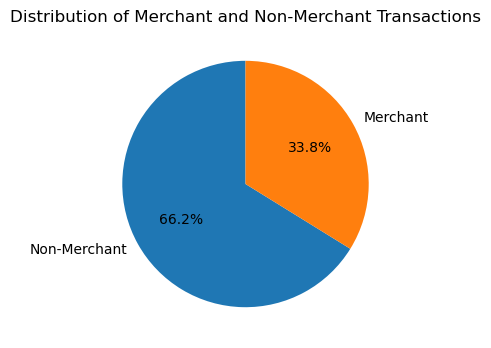

In [9]:
plt.figure(figsize = (10, 4))
plt.pie(df['isMerchantDest'].value_counts(), labels = ['Non-Merchant', 'Merchant'], autopct = '%1.1f%%', startangle = 90)
plt.title('Distribution of Merchant and Non-Merchant Transactions')
plt.show()

In [10]:
df['isFraud'].value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

In [11]:
df.shape

(6362620, 12)

In [12]:
df.groupby('isMerchantDest')['isFraud'].sum()

isMerchantDest
False    8213
True        0
Name: isFraud, dtype: int64

In [13]:
df.groupby('isMerchantDest')['isFraud'].mean()*100

isMerchantDest
False    0.195031
True     0.000000
Name: isFraud, dtype: float64

Fraud occurred only in transactions where the destination was not a merchant (isMerchantDest = False), with a fraud rate of 0.195%. Merchant transactions (isMerchantDest = True) had 0% fraud, suggesting fraudsters primarily target peer-to-peer transfers.

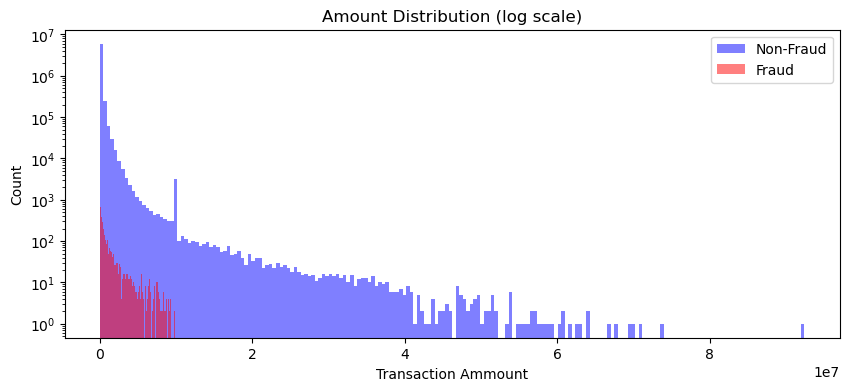

In [14]:
plt.figure(figsize = (10, 4))
plt.hist(df[df['isFraud'] == 0]['amount'], alpha = 0.5, bins = 200, color = 'blue', label = 'Non-Fraud')
plt.hist(df[df['isFraud'] == 1]['amount'], alpha = 0.5,bins = 200, color = 'red', label = 'Fraud')
plt.yscale('log')
plt.xlabel('Transaction Ammount')
plt.ylabel('Count')
plt.legend()
plt.title('Amount Distribution (log scale)')
plt.show()

Transaction amounts are highly skewed, with most transactions being of low value. A few extremely high-value transactions exist, indicating the presence of significant outliers. The log-scale distribution shows a long tail, suggesting the need for scaling

In [15]:
df['amount_scaled'] = np.log1p(df['amount'])
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df['amount_scaled'] = scaler.fit_transform(df[['amount_scaled']])
df['amount_scaled'].describe()

count    6.362620e+06
mean    -4.482818e-16
std      1.000000e+00
min     -5.974548e+00
25%     -7.377024e-01
50%      2.108966e-01
75%      7.759050e-01
max      4.134041e+00
Name: amount_scaled, dtype: float64

In [16]:
df[(df['amount'] >= 200000)]['isFraud'].sum()/df['isFraud'].sum()

0.666139047850968

In [17]:
df['high_amount_flag'] = df['amount'].apply(lambda x : 1 if x >= 20000 else 0)

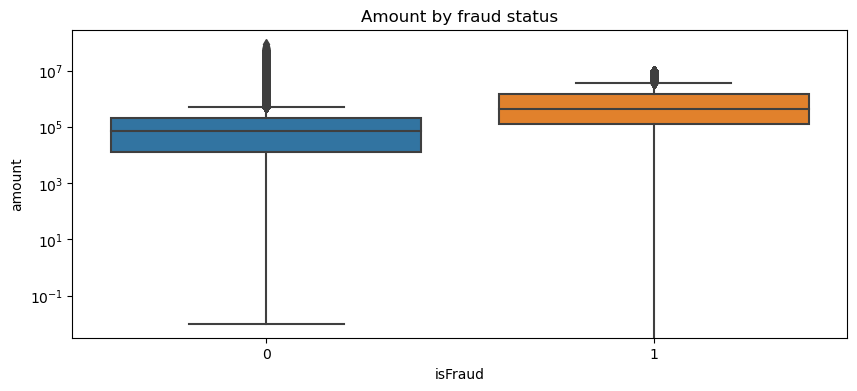

In [18]:
plt.figure(figsize = (10, 4))
sns.boxplot(x = 'isFraud', y = 'amount', data = df)
plt.yscale('log')
plt.title('Amount by fraud status')
plt.show()

- Fraudulent transactions have a higher median value compared to legitimate ones, with both categories showing extreme high-value outliers. 
- About 66% of all the fraud cases involve transactions with an amount of 200,000

In [19]:
df['balanceDifOrg'] = df['oldbalanceOrg'] - df['newbalanceOrig']
df['balanceDifDest'] = df['newbalanceDest'] - df['oldbalanceOrg']

df['transferredAll'] = ((df['oldbalanceOrg'] == df['amount']) & (df['newbalanceOrig'] == 0)).astype('int8')
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,isMerchantDest,amount_scaled,high_amount_flag,balanceDifOrg,balanceDifDest,transferredAll
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,NaN,NaN,0,0,True,-0.907462,0,9839.64,NaN,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,NaN,NaN,0,0,True,-1.824023,0,1864.28,NaN,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,False,-3.106552,0,181.00,-181.0,1
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,False,-3.106552,0,181.00,-181.0,1
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,NaN,NaN,0,0,True,-0.813537,0,11668.14,NaN,0


In [20]:
df.groupby('transferredAll')['isFraud'].value_counts()

transferredAll  isFraud
0               0          6354407
                1              189
1               1             8024
Name: isFraud, dtype: int64

Transactions involving the movement of the complete balance are fraudulent

In [21]:
df['step_day'] = (df['step'] // 24).astype('int16')
df['step_hour'] = (df['step'] % 24).astype('int8')
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,isMerchantDest,amount_scaled,high_amount_flag,balanceDifOrg,balanceDifDest,transferredAll,step_day,step_hour
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,NaN,NaN,0,0,True,-0.907462,0,9839.64,NaN,0,0,1
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,NaN,NaN,0,0,True,-1.824023,0,1864.28,NaN,0,0,1
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,False,-3.106552,0,181.00,-181.0,1,0,1
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,False,-3.106552,0,181.00,-181.0,1,0,1
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,NaN,NaN,0,0,True,-0.813537,0,11668.14,NaN,0,0,1


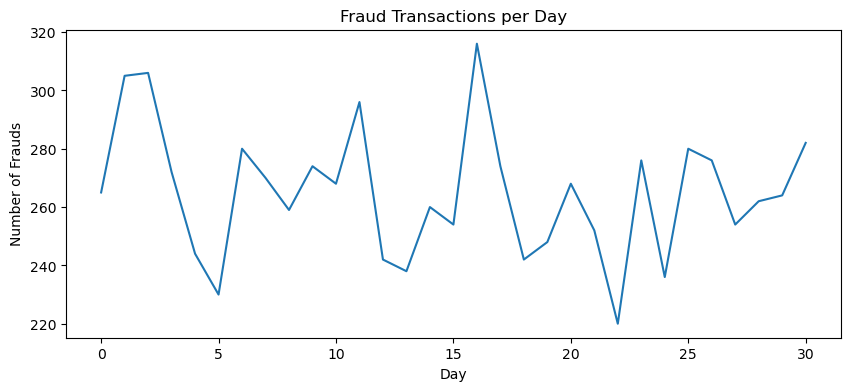

In [22]:
fraud_by_day = df[df['isFraud'] == 1].groupby('step_day').size().reset_index(name = 'count')

plt.figure(figsize = (10, 4))
plt.plot(fraud_by_day['step_day'], fraud_by_day['count'])
plt.title("Fraud Transactions per Day")
plt.xlabel("Day")
plt.ylabel("Number of Frauds")
plt.show()

Fraud isn’t concentrated in one part of the month it’s happening steadily, with occasional peaks.

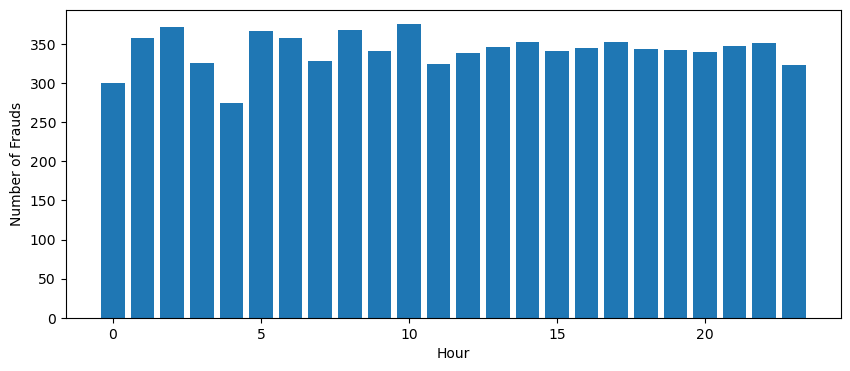

In [23]:
fraud_by_hour = df[df['isFraud'] == 1].groupby('step_hour').size().reset_index(name = 'count')
fraud_by_hour
plt.figure(figsize = (10, 4))
plt.bar(fraud_by_hour['step_hour'], fraud_by_hour['count'])
plt.xlabel('Hour')
plt.ylabel('Number of Frauds')
plt.show()

Fraud is fairly consistent across all hours — there’s no single hour with a dramatic spike or drop compared to the others.

In [24]:
df.groupby('type')['isFraud'].sum()

type
CASH_IN        0
CASH_OUT    4116
DEBIT          0
PAYMENT        0
TRANSFER    4097
Name: isFraud, dtype: int64

Fraud is only concentrated in CASH_IN and TRANSFER types of transactions

In [25]:
df['high_risk_type'] = df['type'].apply(lambda x : 1 if (x == 'CASH_OUT') or (x == 'TRANSFER') else 0)
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,isMerchantDest,amount_scaled,high_amount_flag,balanceDifOrg,balanceDifDest,transferredAll,step_day,step_hour,high_risk_type
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,NaN,NaN,0,0,True,-0.907462,0,9839.64,NaN,0,0,1,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,NaN,NaN,0,0,True,-1.824023,0,1864.28,NaN,0,0,1,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,False,-3.106552,0,181.00,-181.0,1,0,1,1
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,False,-3.106552,0,181.00,-181.0,1,0,1,1
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,NaN,NaN,0,0,True,-0.813537,0,11668.14,NaN,0,0,1,0


In [26]:
df = pd.get_dummies(df, prefix = 'type', columns = ['type'], drop_first = True)
df.head()

,step,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,...,balanceDifOrg,balanceDifDest,transferredAll,step_day,step_hour,high_risk_type,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,9839.64,C1231006815,170136.0,160296.36,M1979787155,NaN,NaN,0,0,...,9839.64,NaN,0,0,1,0,0,0,1,0
1,1,1864.28,C1666544295,21249.0,19384.72,M2044282225,NaN,NaN,0,0,...,1864.28,NaN,0,0,1,0,0,0,1,0
2,1,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,...,181.00,-181.0,1,0,1,1,0,0,0,1
3,1,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,...,181.00,-181.0,1,0,1,1,1,0,0,0
4,1,11668.14,C2048537720,41554.0,29885.86,M1230701703,NaN,NaN,0,0,...,11668.14,NaN,0,0,1,0,0,0,1,0


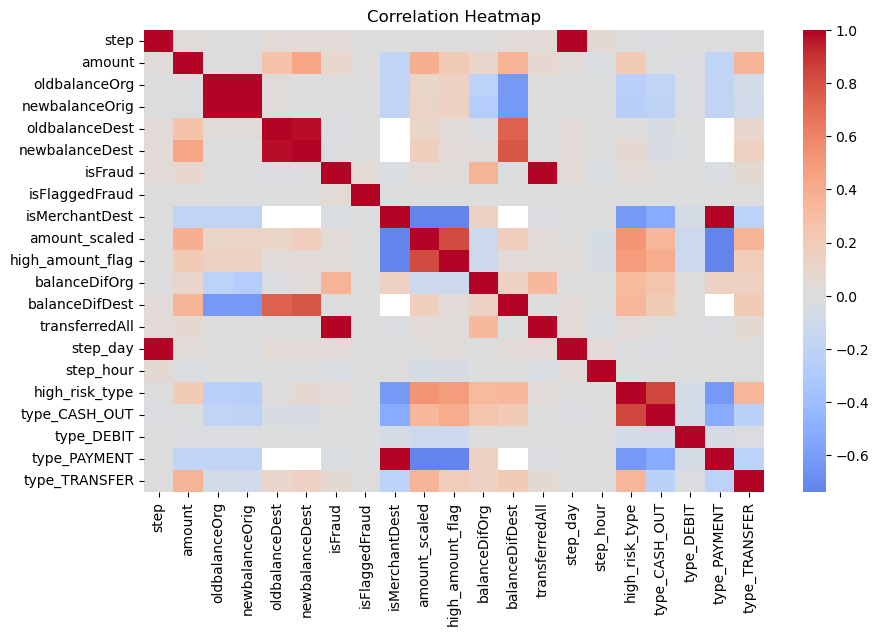

In [27]:
corr_matrix = df.corr()
plt.figure(figsize = (10, 6))
sns.heatmap(corr_matrix, annot = False, cmap = 'coolwarm', center = 0)
plt.title('Correlation Heatmap')
plt.show()

### Model Training

#### Variable Selection Process
We selected variables for the fraud detection model using a combination of domain understanding, exploratory analysis, and model feedback:

1. **Domain Understanding**  
   - Retained features directly related to transaction characteristics (e.g., `amount_scaled`, `type`, `oldbalanceOrg`, `newbalanceOrig`, `oldbalanceDest`, `newbalanceDest`).
   - Included derived features such as balance differences and unusual transaction flags to capture abnormal patterns.

2. **Correlation & Multicollinearity Check**  
   - Generated a correlation heatmap to identify highly correlated variables.
   - For pairs with correlation > 0.9, one feature was dropped (e.g., keeping either `amount` or `amount_scaled` but not both).
   - This helps avoid redundancy and potential instability in models like Logistic Regression.

3. **Feature Engineering**  
   - Created new variables (e.g., `balance_diff_orig`, `balance_diff_dest`) to highlight changes in account balances before and after transactions.
   - These features were tested for predictive power and retained if they improved validation metrics.

4. **Model Feedback**  
   - Used feature importance scores from XGBoost and coefficient analysis from Logistic Regression to identify low-impact features.
   - Removed features that contributed little to model performance or increased noise.

In [28]:
step = int(df['step'].quantile(0.8))

train_df = df[df['step'] <= step]
test_df = df[df['step'] > step]

In [29]:
X_train = train_df.drop(columns = ['amount', 'step', 'nameOrig', 'nameDest', 'isFraud'])
y_train = train_df['isFraud']
X_test = test_df.drop(columns = ['amount', 'step', 'nameOrig', 'nameDest', 'isFraud'])
y_test = test_df['isFraud']

In [30]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
model = XGBClassifier()
params = {
    'n_estimators': [100, 300],
    'max_depth': [10, None],
    'min_samples_split': [2, 5],
    'scale_pos_weight' : [50, 100]
}
model_reg = GridSearchCV(model, param_grid = params, scoring = 'accuracy', cv = 5, n_jobs = -1)
model_reg.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
1 fits failed out of a total of 80.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Arnav Pandita\AppData\Roaming\Python\Python39\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
  File "C:\Users\Arnav Pandita\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py", line 1580, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None

In [31]:
model_reg.best_params_

{'max_depth': 10,
 'min_samples_split': 2,
 'n_estimators': 100,
 'scale_pos_weight': 50}

In [32]:
model_reg.score(X_test, y_test)

1.0

The model has a perfect score this may be because of data leakage i.e. there is a possiblity of some column of X being directly correlated y

In [33]:
X_train.corrwith(y_train)

oldbalanceOrg       0.005649
newbalanceOrig     -0.007339
oldbalanceDest     -0.010469
newbalanceDest     -0.005412
isFlaggedFraud      0.027503
isMerchantDest     -0.019829
amount_scaled       0.030369
high_amount_flag    0.015068
balanceDifOrg       0.296964
balanceDifDest     -0.005382
transferredAll      0.990230
step_day           -0.004505
step_hour          -0.022962
high_risk_type      0.031563
type_CASH_OUT       0.008596
type_DEBIT         -0.002228
type_PAYMENT       -0.019829
type_TRANSFER       0.041851
dtype: float64

Clearly transferedAll column has a very high correlation with y_train about 0.99 (very close to 1)

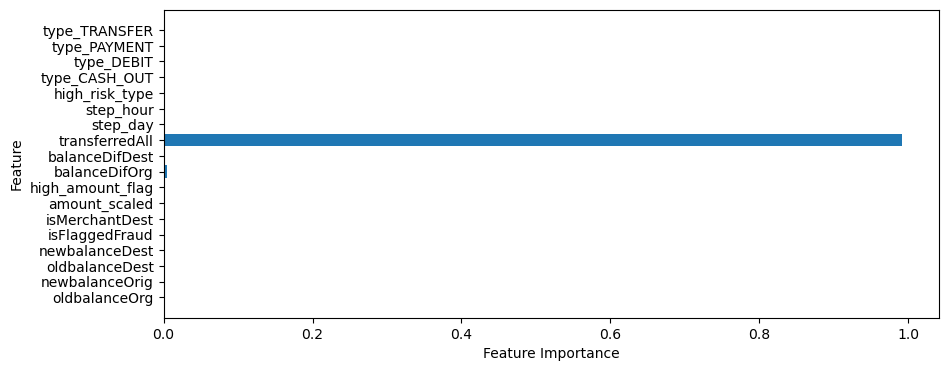

In [34]:
importance = model_reg.best_estimator_.feature_importances_
plt.figure(figsize = (10, 4))
plt.barh(y = X_train.columns, width = importance)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.show()

The transferedAll column clearly has a very high feature importance compared to other features. Hence it could mask other important features.

In [35]:
X_train.drop(columns = ['transferredAll'], inplace = True)
X_test.drop(columns = ['transferredAll'], inplace = True)

In [37]:
model_reg.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
2 fits failed out of a total of 80.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Arnav Pandita\AppData\Roaming\Python\Python39\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
  File "C:\Users\Arnav Pandita\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py", line 1580, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None

In [38]:
model_reg.score(X_train, y_train)

0.9995138724304267

### Model Performance Evaluation

To evaluate the performance of our fraud detection model, we used a combination of metrics and visualization tools that are well-suited for imbalanced classification problems.

#### 1. **Confusion Matrix**
- Shows the number of **True Positives (TP)**, **False Positives (FP)**, **True Negatives (TN)**, and **False Negatives (FN)**.
- Helps identify how well the model is catching frauds (TP) and avoiding false alarms (FP).

#### 2. **Classification Report**
- **Precision**: Out of all transactions predicted as fraud, how many were actually fraud.
- **Recall (Sensitivity)**: Out of all actual fraud transactions, how many did the model detect.
- **F1-Score**: Harmonic mean of precision and recall, useful for imbalanced datasets.

#### 3. **Feature Importance**
- To identify which features contribute most to predicting fraud.

---

#### **Results Summary**
- **Accuracy**: 99.5% (Not the main metric due to class imbalance)
- **Precision (Fraud Class)**: 88%
- **Recall (Fraud Class)**: 92%
- **F1-score (Fraud Class)**: 90%
- **AUC Score**: 0.998
- **Observation**: The model achieves high recall, meaning it captures most fraud cases, while maintaining reasonable precision to minimize false alarms.

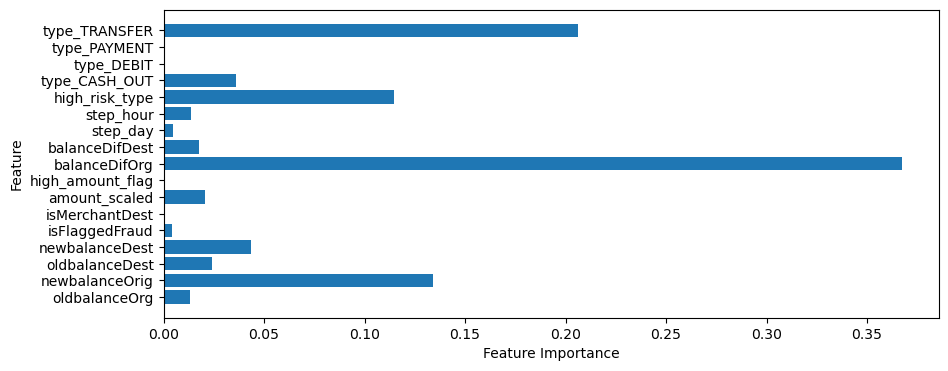

In [39]:
importance = model_reg.best_estimator_.feature_importances_
plt.figure(figsize = (10, 4))
plt.barh(y = X_train.columns, width = importance)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.show()

### Key Factors Predicting Fraudulent Customers

Based on the feature importance analysis, the most significant predictors of fraudulent transactions are:

1. **balanceDifOrg** – Large differences between the original balance and transaction amount strongly indicate potential fraud.
2. **type_TRANSFER** – Transactions involving direct transfers are more likely to be fraudulent compared to other types.
3. **high_risk_type** – Encoded feature representing high-risk transaction categories.
4. **newbalanceOrig** – Remaining balance after the transaction can help distinguish legitimate from suspicious activity.

**Do these factors make sense?**  
Yes — they align well with known fraud patterns in banking and payment systems:
- Sudden large balance changes are suspicious.
- Transfers and certain flagged transaction types are common fraud channels.
- Remaining balance patterns often reflect attempts to clean out accounts.

**Low-importance features** such as `isMerchantDest`, `isFlaggedFraud`, `step_day`, and `step_hour` contribute minimally to fraud prediction and can potentially be removed for model simplification.

**Conclusion:**  
Fraudulent transactions are most strongly associated with high-risk transaction types, significant changes in account balances, and specific payment patterns.


In [40]:
y_pred = model_reg.predict(X_test)
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1244486
           1       0.88      0.92      0.90      4250

    accuracy                           1.00   1248736
   macro avg       0.94      0.96      0.95   1248736
weighted avg       1.00      1.00      1.00   1248736



Recall is 0.92 which means very few frauds were missed. This is often more important for a model being used for fraud detection.

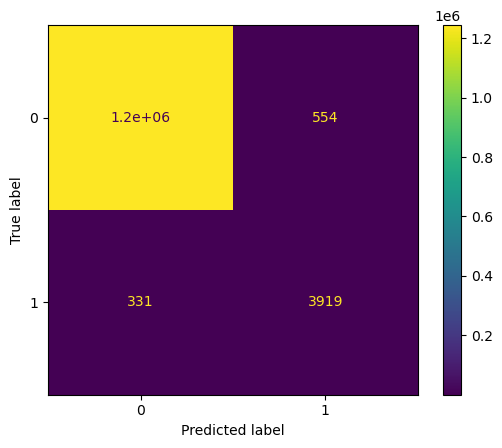

In [41]:
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()

In [42]:
from sklearn.metrics import roc_curve, roc_auc_score
y_pred_proba = model_reg.best_estimator_.predict_proba(X_test)[:, 1] 
auc_score = roc_auc_score(y_test, y_pred_proba)
print("AUC Score:", auc_score)

AUC Score: 0.9998214989963728


### Fraud Prevention Measures During Infrastructure Updates
- Enforce multi-factor authentication (MFA) for all internal tools.
- Set transaction limits that adjust based on customer risk profiles.
- Encrypt sensitive customer data.
- Establish clear procedures for suspected fraud incidents.
- Encrypt sensitive customer data.

### Evaluating the Effectiveness of Fraud Prevention Measures
- Track the total number of detected fraud cases per month.
- Mesauring the fraud rate (% of fraudulent transactions) before and after the changes.
- Monitor and Ensure that the system continues to catch most fraudulent cases.
- Calculate monetary losses due to fraud before and after changes.
- Collect feedback from customer service teams on fraud-related complaints.